# COGS 109 Final Project

### Chen Meng, c5meng@ucsd.edu
### [Your name] 

In [15]:
# Import libraries
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Part 1: Acquiring, cleaning, and examining data

In [16]:
# Load headers for the data:
header = open("header.txt", "r").read()
rawLines = [l for l in header.split('--') if len(l) != 0]
colTitles = [l.split(':')[0].strip() for l in rawLines]
print("Total columns:", len(colTitles))
#print(colTitles)

# Initial cleaning of the data
# source: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
data = pd.read_csv("CommViolPredUnnormalizedData.txt", 
                   names=colTitles, na_values="?") # Missing values are marked with "?", treat as Nan
# Variables of interest:
# medIncome - median household income
# PctNotHSGrad - percentage of people 25 and over that are not high school graduates
# ViolentCrimesPerPop - total number of violent crimes per 100K popuation
# nonViolPerPop - total number of non-violent crimes per 100K popuation
data = data[["communityname","state",
             "medIncome","PctNotHSGrad","ViolentCrimesPerPop","nonViolPerPop"]]
data = data.dropna(0) # drop rows with invalid(nan) values

# Examine the data:
data

Total columns: 147


,communityname,state,medIncome,PctNotHSGrad,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,75122,9.90,41.02,1394.59
1,Marpletownship,PA,47917,13.72,127.56,1955.95
2,Tigardcity,OR,35669,9.09,218.59,6167.51
5,Springfieldcity,MO,21577,23.03,442.95,6867.42
6,Norwoodtown,MA,42805,13.89,226.63,1890.88
...,...,...,...,...,...,...
2210,Mercedcity,CA,24727,30.87,545.75,7356.84
2211,Pinevillecity,LA,20321,27.71,124.10,5824.44
2212,Yucaipacity,CA,27182,26.14,353.83,4654.20
2213,Beevillecity,TX,19899,39.63,691.17,5340.87


## Part 2: Data exploration

Text(0.5, 1.0, 'Histogram of Log Median Household Income')

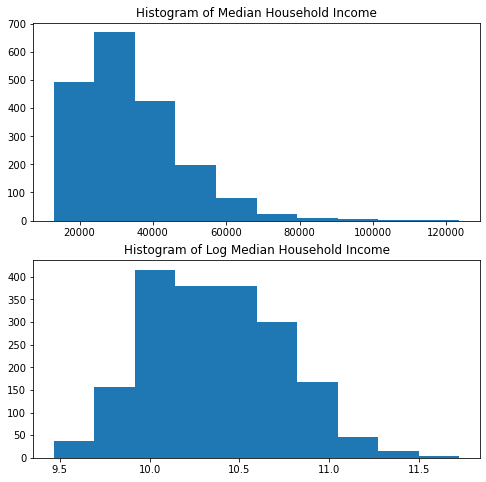

In [14]:
medIncome = data["medIncome"]
logMedIncome = np.log(medIncome.to_numpy())

fig, axs = plt.subplots(2)
axs[0].hist(medIncome)
axs[0].set_title("Histogram of Median Household Income per Year")
axs[1].hist(logMedIncome)
axs[1].set_title("Histogram of Log Median Household Income per Year")

Text(0.5, 1.0, 'Histogram of Percent of Non Highschool Graduates')

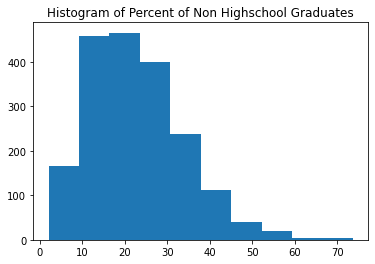

In [17]:
pctNonGrad = data["PctNotHSGrad"]
plt.hist(pctNonGrad)
plt.title("Histogram of Percent of Non Highschool Graduates")

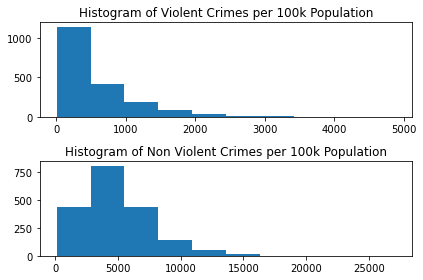

In [20]:
violentCrime = data["ViolentCrimesPerPop"]
nonViolentCrime = data["nonViolPerPop"]
fig, axs = plt.subplots(2)
axs[0].hist(violentCrime)
axs[0].set_title("Histogram of Violent Crimes per 100k Population")
axs[1].hist(nonViolentCrime)
axs[1].set_title("Histogram of Non Violent Crimes per 100k Population")
fig.tight_layout()

## Part 3: Regression Model Construction with Cross-validation

[ 1.18978025e+03 -1.78537683e-02]


Text(0, 0.5, 'Violent Crimes')

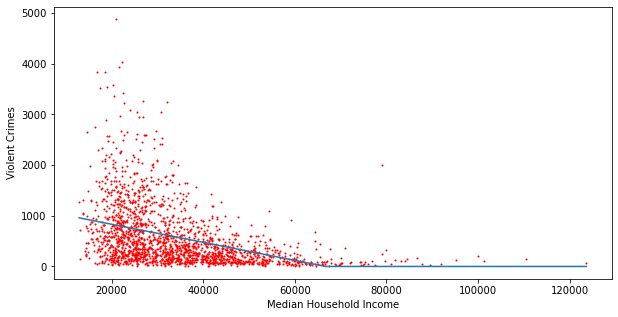

In [32]:
# Model 1: Violent crimes ~ income
X = data["medIncome"].to_numpy()
Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w1 = np.linalg.lstsq(A, Y, rcond=None)[0] #ViolentCrimes=w0+w1*medIncome
print(w1)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w1[0] + w1[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Median Household Income")
plt.ylabel("Violent Crimes")

[7616.24304508 -678.68372334]


Text(0, 0.5, 'Violent Crimes')

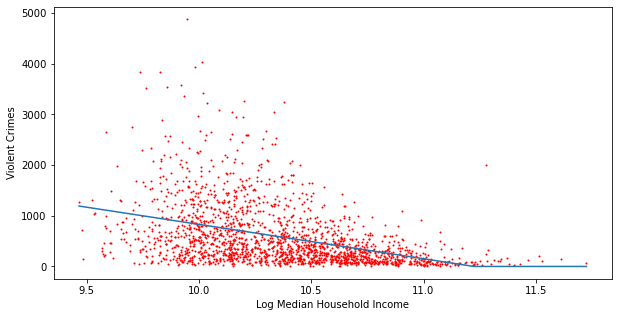

In [33]:
# Model 2: Violent crimes ~ log(income)
X = np.log(data["medIncome"].to_numpy())
Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w2 = np.linalg.lstsq(A, Y, rcond=None)[0] #ViolentCrimes = min(w0+w1*log(income), 0)
print(w2)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w2[0] + w2[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Log Median Household Income")
plt.ylabel("Violent Crimes")

[ 3.23329338 25.61494757]


Text(0, 0.5, 'Violent Crimes')

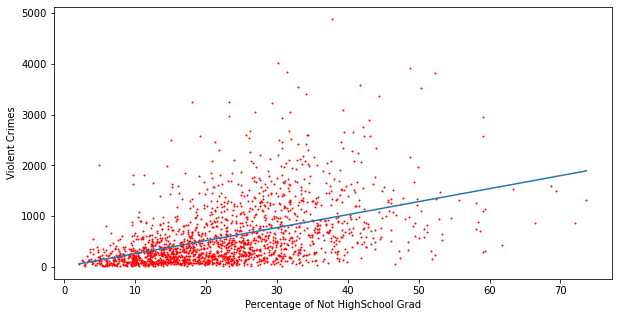

In [36]:
# Model 3: Violent crimes ~ Education
X = data["PctNotHSGrad"].to_numpy()
Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1)
w3 = np.linalg.lstsq(A, Y, rcond=None)[0] #violentcrimes = w0+w1*education
print(w3)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w3[0] + w3[1]*x).clip(min=0))(x_values) 

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Percentage of Not HighSchool Grad")
plt.ylabel("Violent Crimes")


In [45]:
# Model 4: Violent crimes ~ Income, Education
X = data[["medIncome", "PctNotHSGrad"]].to_numpy()
Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
product = np.array([X[i,0]*X[i,1] for i in range(X.shape[0])])
A = np.append(ones, X, axis=1)
A = np.append(A, product.reshape(n,1), axis=1)
w4 = np.linalg.lstsq(A, Y, rcond=None)[0] #ViolentCrimes=w0+w1*medIncome+w2*education+w3*income*education
print(w4)

[ 2.73565586e+02 -3.02583956e-03  2.83689029e+01 -3.43220598e-04]


[ 8.20497993e+03 -9.61097266e-02]


Text(0, 0.5, 'Non Violent Crimes')

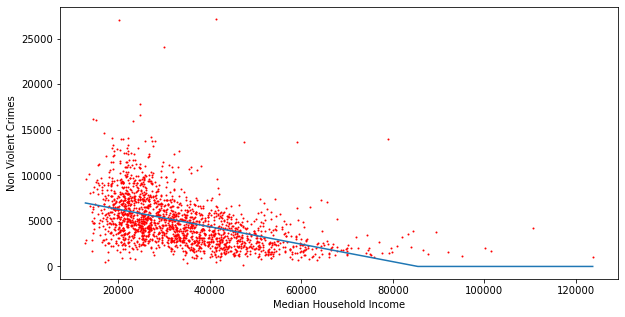

In [46]:
# Model 5: Non Violent crimes ~ income
X = data["medIncome"].to_numpy()
Y = data["nonViolPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w5 = np.linalg.lstsq(A, Y, rcond=None)[0] #NonViolentCrimes=w0+w1*medIncome
print(w5)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w5[0] + w5[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Median Household Income")
plt.ylabel("Non Violent Crimes")

[2853.21100372   92.18960192]


Text(0, 0.5, 'Non Violent Crimes')

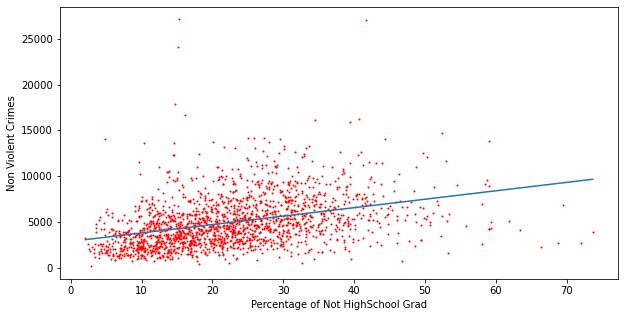

In [48]:
# Model 6: Non Violent crimes ~ education
X = data["PctNotHSGrad"].to_numpy()
Y = data["nonViolPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w6 = np.linalg.lstsq(A, Y, rcond=None)[0] #NonViolentCrimes=w0+w1*education
print(w6)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w6[0] + w6[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Percentage of Not HighSchool Grad")
plt.ylabel("Non Violent Crimes")

In [21]:
# Model 7: Non Violent crimes ~ Income, Education
X = data[["medIncome", "PctNotHSGrad"]].to_numpy()
Y = data["nonViolPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
product = np.array([X[i,0]*X[i,1] for i in range(X.shape[0])])
A = np.append(ones, X, axis=1)
A = np.append(A, product.reshape(n,1), axis=1)
w7 = np.linalg.lstsq(A, Y, rcond=None)[0] #NonViolentCrimes=w0+w1*medIncome+w2*education+w3*income*education
print(w7)

[ 6.38054028e+03 -5.03421223e-02  9.30599746e+01 -2.74264711e-03]


## Part 4: Model Comparison

## Part 5: Analysis and Conclusion